In [1]:
import pandas as pd
from pathlib import Path

In [2]:
#loading modules
import math, random, os, re, time
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, Model
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL
import gc
import cv2
import seaborn as sns
from kaggle_datasets import KaggleDatasets
from tqdm import tqdm


2025-08-19 01:40:41.325029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755567641.336868       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755567641.340725       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-19 01:40:41.355992: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.


AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
#REPLICAS = 8
print(f'REPLICAS: {REPLICAS}')


REPLICAS: 1


In [4]:
#loading data
dirname='../input/siim-isic-melanoma-classification/'
train = pd.read_csv(dirname+'train.csv')
test = pd.read_csv(dirname + 'test.csv')
print(train.head())
print(len(train))
print(len(test))
print(train['target'].value_counts())


     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
3  ISIC_0074268  IP_8723313  female        55.0               upper extremity   
4  ISIC_0074311  IP_2950485  female        40.0               lower extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2   unknown           benign       0  
3   unknown           benign       0  
4   unknown           benign       0  
28984
4142
target
0    28471
1      513
Name: count, dtype: int64


<Axes: ylabel='count'>

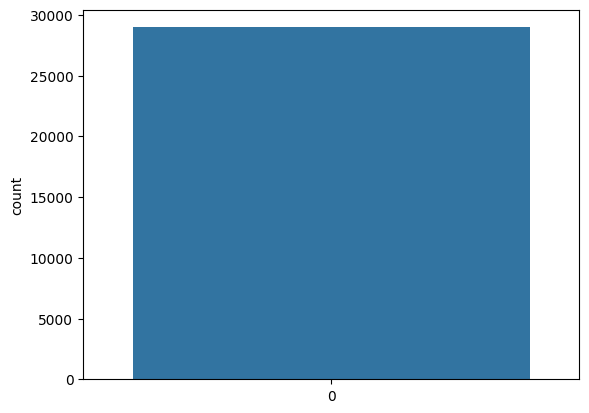

In [5]:
sns.countplot(train['target'])


In [6]:
GCS_PATH = KaggleDatasets().get_gcs_path()
train_filenames = tf.io.gfile.glob(GCS_PATH + '/tfrecords/train*.tfrec')
test_filenames = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test*.tfrec')


BackendError: Unexpected response from the service. Response: {'errors': ['Unauthenticated'], 'error': {'code': 16}, 'wasSuccessful': False}.

In [7]:
!gsutil ls $GCS_PATH


You are attempting to perform an operation that requires a project id, with none configured. Please re-run gsutil config and make sure to follow the instructions for finding and entering your default project id.


In [8]:
train_filenames , valid_filenames = train_test_split(train_filenames , test_size=0.2,shuffle=True)


NameError: name 'train_filenames' is not defined

In [9]:
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024,1024]
AUTO = tf.data.experimental.AUTOTUNE
imSize = 1024


In [10]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    image = tf.image.resize(image, [imSize,imSize])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['target'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0, 2)
    # image = tf.image.random_hue(image,0.15)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(train_filenames, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_val_dataset():
    dataset = load_dataset(valid_filenames, labeled=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(train_filenames)
NUM_TEST_IMAGES = count_data_items(valid_filenames)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} labeled validation images'.format(NUM_TRAINING_IMAGES, NUM_TEST_IMAGES))


NameError: name 'train_filenames' is not defined

In [11]:
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
# print("Test data shapes:")


NameError: name 'train_filenames' is not defined

In [12]:
def res_block(X_in, channels):
    X = layers.Conv2D(channels, (3,3), strides=(1,1), padding='same' )(X_in)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU()(X)
    
    X = layers.Conv2D(channels, (3,3), strides=(1,1), padding='same')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Add()([X, X_in])
    X = layers.LeakyReLU()(X)
    
    return X


In [13]:
#model
def my_model():
    X_in = layers.Input((1024, 1024, 3))
    
    X = layers.AveragePooling2D(pool_size=(2, 2), strides=2, name='avg_pool1')(X_in)
    
    X = layers.Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv1')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)

    X = res_block(X, 64)
    
    X = layers.MaxPool2D(pool_size=(2, 2), strides=2, name='max_pool1')(X)
    X = layers.MaxPool2D(pool_size=(2, 2), strides=2, name='max_pool1.2')(X)

    X = layers.Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv2')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    
    X = res_block(X, 128)
    
    X = layers.MaxPool2D(pool_size = (2,2), strides=2, name='max_pool2')(X)

    X = layers.Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv3')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)

    X = res_block(X, 256)
    
    X = layers.MaxPool2D(pool_size = (2,2), strides=2, name='max_pool3')(X)

    X = res_block(X, 256)
    
    X = layers.MaxPool2D(pool_size = (2,2), strides=2, name='max_pool4')(X)
    
    X = res_block(X, 256)
    
    X = layers.MaxPool2D(pool_size = (2,2), strides=2, name='max_pool5')(X)
    
    X = layers.Flatten()(X)
    X = layers.Dense(4096, activation='relu', name='fc1')(X)
    X = layers.Dense(1024, activation='relu', name='fc2')(X)
    X_out = layers.Dense(1, activation='sigmoid', name='answer')(X)

    model = Model(inputs=X_in, outputs=X_out, name='pinnet')
    
    return model


In [14]:
with strategy.scope():
    model = my_model()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


2025-08-19 01:40:48.983719: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [15]:
model.summary()


Model: "pinnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_pool1           │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (AveragePooling2D)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 512, 512,  │      1,792 │ avg_pool1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 512, 512,  │          0 │ add[0][0]         │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool1           │ (None, 256, 256,  │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool1.2         │ (None, 128, 128,  │          0 │ max_pool1[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 128, 128,  │     73,856 │ max_pool1.2[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2[0][0]       │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat

 Total params: 75,599,105 (288.39 MB)

 Trainable params: 75,594,369 (288.37 MB)

 Non-trainable params: 4,736 (18.50 KB)

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
def callback():
    cb = []
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.3, patience=5,
                                   verbose=1, mode='auto',
                                   epsilon=0.0001, cooldown=1, min_lr=0.00001)
    cb.append(reduceLROnPlat)
    return cb


In [17]:
cb = callback()
#train and validate
epochs = 10
history = model.fit(get_training_dataset(), epochs=epochs, verbose=True, steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE,
                    validation_data = get_val_dataset(), validation_steps =NUM_TEST_IMAGES//BATCH_SIZE, callbacks=cb) # callbacks = cb,


NameError: name 'train_filenames' is not defined

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


NameError: name 'history' is not defined

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


NameError: name 'history' is not defined

In [20]:
num_test_images = count_data_items(test_filenames)
num_test_images


NameError: name 'test_filenames' is not defined

In [21]:
def get_test_dataset(ordered=False):
    dataset = load_dataset(test_filenames, labeled=False,ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

test_dataset = get_test_dataset(ordered=True)


NameError: name 'test_filenames' is not defined

In [22]:
print('Computing predictions...')
test_images_ds = test_dataset.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds).flatten()
print(probabilities)


print('Generating submission.csv file...')
test_ids_ds = test_dataset.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(num_test_images))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, probabilities]), fmt=['%s', '%f'], delimiter=',', header='image_name,target', comments='')


Computing predictions...


NameError: name 'test_dataset' is not defined